In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../data/2_extracted_works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)


In [2]:
works_bjp = pl.read_csv("../data/2_extracted_works/works_bjp.csv")
works_bjp = works_bjp.filter(pl.col("year") != 2025)

In [3]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) 

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns( #remove abstract, add words : survey, overview, state of?
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

works

shape: (689_361, 1_080)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ ros stress  ┆ 2004 ┆ 1881        ┆ 1          ┆ … ┆ 35.103559 ┆ 3          ┆ false  ┆ false      │
│ in cancer   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ cells and…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ aminoglycos ┆ 2010 ┆ 1294        ┆ 1          ┆ … ┆ 24.857588 ┆ 2          ┆ false  ┆ false      │
│ ide         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ modifying   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ enzym…      ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ overcoming  ┆ 2015 ┆ 898         ┆ 2          ┆ … ┆ 23.127161 ┆ 6          ┆ false  ┆ false      │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ blood–brain ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ tum…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ targeting   ┆ 2008 ┆ 786         ┆ 1          ┆ … ┆ 14.902469 ┆ 4          ┆ false  ┆ false      │
│ the pi3k/ak ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t/mtor pa…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ if not      ┆ 2001 ┆ 722         ┆ 1          ┆ … ┆ 12.263251 ┆ 3          ┆ false  ┆ false      │
│ apoptosis,  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ then what?  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t…          ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│ contributor ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ s           ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ copyright   ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ preface     ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ dendritic   ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ cells in    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ inducti…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ protein con ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 6          ┆ false  ┆ false      │
│ formation   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ affects t…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [4]:
year_begin = 1920
year_end = 2024
works_bjp = works_bjp.with_columns(
    age=2025 - pl.col("year")
)

cbc_per_year = (
    works
    .group_by("year")
    .agg(
        pl.col("cited_by_count").mean().alias("mean_cited_by_count")
    )
)


works_bjp = works_bjp.join(
    cbc_per_year,
    on="year",
    how="left"
)


works_bjp = (
    works_bjp
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)

bjp_cols_authors = [col for col in works_bjp.columns if col.startswith("author_")]

works_bjp = works_bjp.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in bjp_cols_authors]
    )

)

works_bjp = works_bjp.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works_bjp = works_bjp.with_columns( #remove abstract, add words : survey, overview, state of?
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works_bjp = works_bjp.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works_bjp = works_bjp.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


bjp_group_references_mean = (
    works_bjp.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works_bjp

shape: (26_115, 394)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ animal      ┆ 2010 ┆ 3465        ┆ 1          ┆ … ┆ 66.562243 ┆ 5          ┆ false  ┆ false      │
│ research:   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ reporting   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ <i>…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ principles  ┆ 2010 ┆ 2474        ┆ 1          ┆ … ┆ 47.52525  ┆ 4          ┆ true   ┆ false      │
│ of early    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ drug disco… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ measuring   ┆ 2004 ┆ 2200        ┆ 1          ┆ … ┆ 41.056794 ┆ 2          ┆ true   ┆ false      │
│ reactive    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ species     ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ guide to    ┆ 2011 ┆ 2073        ┆ 1          ┆ … ┆ 43.369663 ┆ 3          ┆ false  ┆ false      │
│ receptors   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ channel…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ characteriz ┆ 1990 ┆ 1876        ┆ 1          ┆ … ┆ 74.914326 ┆ 5          ┆ false  ┆ false      │
│ ation of    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ three inhi… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│             ┆ 1986 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ transdermal ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ iontophores ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ is - ro…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ oral commun ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ ications    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ interleukin ┆ 1989 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ 1 and lipop ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ olysacc…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ effect of   ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 3          ┆ false  ┆ false      │
│ 8-br-cgmp   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ on current… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [5]:
import ast
from itertools import chain

def prepare_concepts_top20_norm(df):
    parsed = [
        [c["display_name"] for c in ast.literal_eval(x)] if x not in [None, ""] else []
        for x in df["concepts"].to_list()
    ]

    concepts = pl.Series("concept", list(chain.from_iterable(parsed)))
    citations = pl.Series(
        "cited_by_count",
        list(chain.from_iterable(
            [[c] * len(p) for c, p in zip(df["cited_by_count"].to_list(), parsed)]
        ))
    )
    mncs = pl.Series(
        "mncs",
        list(chain.from_iterable(
            [[m] * len(p) for m, p in zip(df["mncs"].to_list(), parsed)]
        ))
    )

    exploded = pl.DataFrame({"concept": concepts, "cited_by_count": citations, "mncs": mncs})

    df_top20 = (
        exploded
        .group_by("concept")
        .agg([
            pl.len().alias("n_articles"),
            pl.mean("mncs").alias("mean_mncs"),
            pl.sum("cited_by_count").alias("total_citations")
        ])
        .sort("n_articles", descending=True)
        .head(20)
        .to_pandas()
    )
    
    df_top20["mean_mncs_norm"] = df_top20["mean_mncs"] / df_top20["mean_mncs"].max()
    df_top20["n_articles_norm"] = df_top20["n_articles"] / df_top20["n_articles"].max()
    df_top20["total_citations_norm"] = df_top20["total_citations"] / df_top20["total_citations"].max()

    return df_top20




In [6]:
top_concepts_bjp = prepare_concepts_top20_norm(works_bjp)
top_concepts_q1 = prepare_concepts_top20_norm(works)


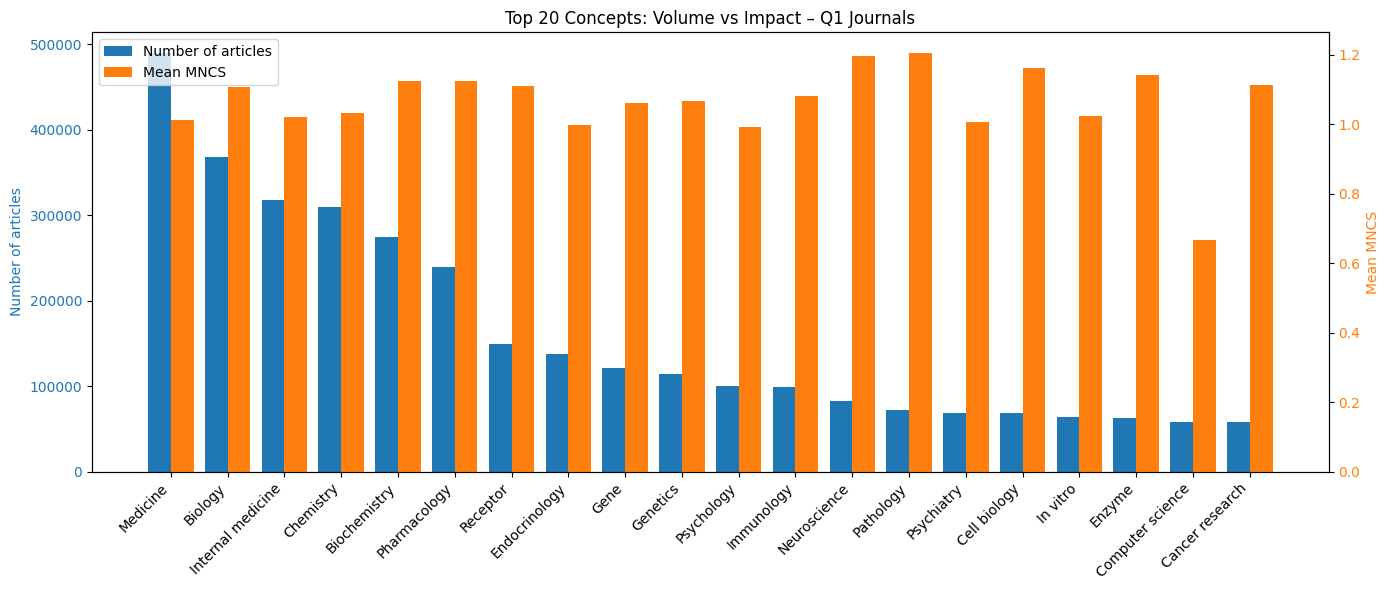

In [7]:

x = np.arange(len(top_concepts_q1["concept"]))
width = 0.4

fig, ax1 = plt.subplots(figsize=(14, 6))

color_articles = "tab:blue"
color_mncs = "tab:orange"

bars1 = ax1.bar(
    x - width/2,
    top_concepts_q1["n_articles"],
    width=width,
    color=color_articles,
    label="Number of articles"
)

ax1.set_ylabel("Number of articles", color=color_articles)
ax1.tick_params(axis="y", labelcolor=color_articles)

ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2,
    top_concepts_q1["mean_mncs"],
    width=width,
    color=color_mncs,
    label="Mean MNCS"
)

ax2.set_ylabel("Mean MNCS", color=color_mncs)
ax2.tick_params(axis="y", labelcolor=color_mncs)

# Axe X
ax1.set_xticks(x)
ax1.set_xticklabels(
    top_concepts_q1["concept"],
    rotation=45,
    ha="right"
)

plt.title("Top 20 Concepts: Volume vs Impact – Q1 Journals")

ax1.legend(
    handles=[bars1, bars2],
    labels=["Number of articles", "Mean MNCS"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


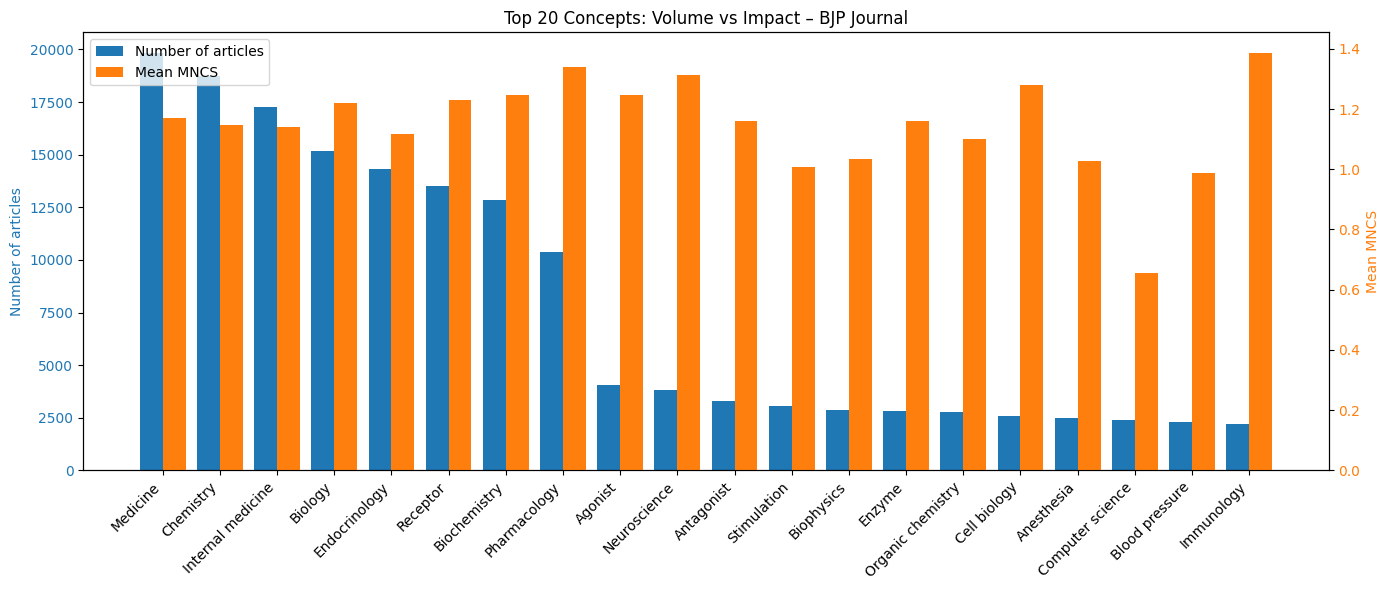

In [8]:

x = np.arange(len(top_concepts_bjp["concept"]))
width = 0.4

fig, ax1 = plt.subplots(figsize=(14, 6))

color_articles = "tab:blue"
color_mncs = "tab:orange"

bars1 = ax1.bar(
    x - width/2,
    top_concepts_bjp["n_articles"],
    width=width,
    color=color_articles,
    label="Number of articles"
)

ax1.set_ylabel("Number of articles", color=color_articles)
ax1.tick_params(axis="y", labelcolor=color_articles)

ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2,
    top_concepts_bjp["mean_mncs"],
    width=width,
    color=color_mncs,
    label="Mean MNCS"
)

ax2.set_ylabel("Mean MNCS", color=color_mncs)
ax2.tick_params(axis="y", labelcolor=color_mncs)

# Axe X
ax1.set_xticks(x)
ax1.set_xticklabels(
    top_concepts_bjp["concept"],
    rotation=45,
    ha="right"
)

plt.title("Top 20 Concepts: Volume vs Impact – BJP Journal")

ax1.legend(
    handles=[bars1, bars2],
    labels=["Number of articles", "Mean MNCS"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


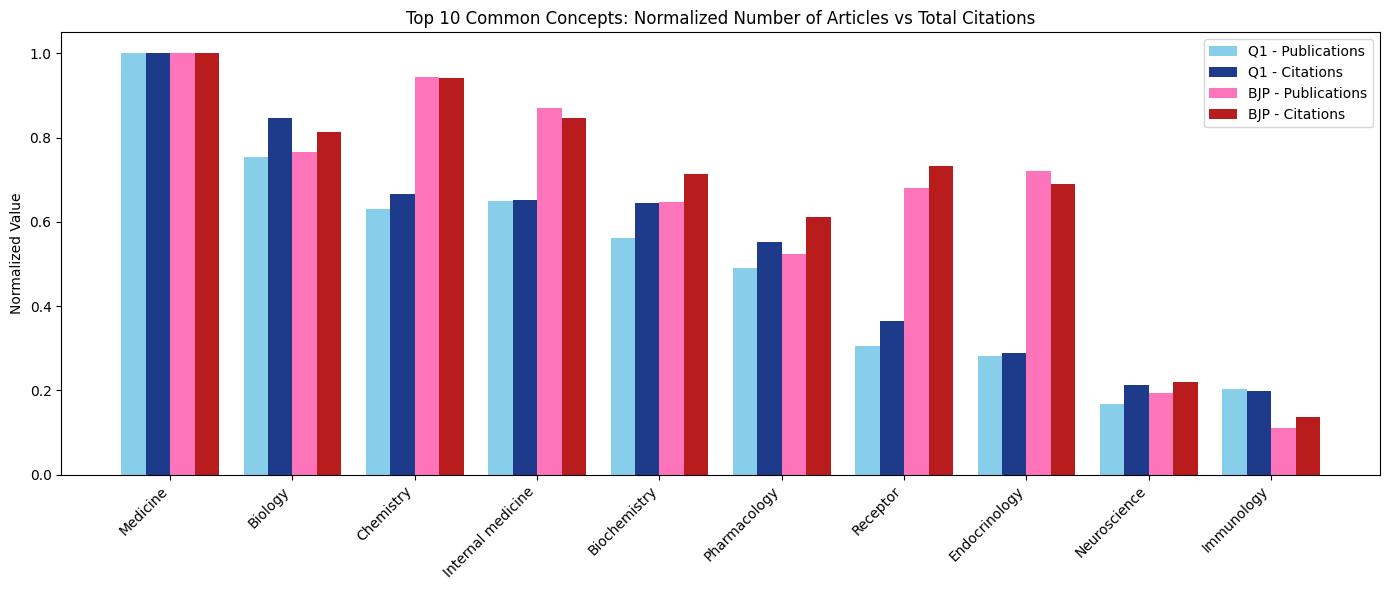

In [9]:
common_concepts = set(top_concepts_bjp["concept"]) & set(top_concepts_q1["concept"])

df_common = pd.merge(
    top_concepts_bjp, 
    top_concepts_q1, 
    on="concept", 
    suffixes=("_bjp", "_q1")
)
df_common = df_common[df_common["concept"].isin(common_concepts)]
df_common["total_citations_sum"] = df_common["total_citations_bjp"] + df_common["total_citations_q1"]
df_common = df_common.sort_values("total_citations_sum", ascending=False).head(10)

x = np.arange(len(df_common))
width = 0.2

plt.figure(figsize=(14,6))

plt.bar(x - 1.5*width, df_common["n_articles_norm_q1"], width, label="Q1 - Publications", color="#87CEEB")
plt.bar(x - 0.5*width, df_common["total_citations_norm_q1"], width, label="Q1 - Citations", color="#1E3A8A")
plt.bar(x + 0.5*width, df_common["n_articles_norm_bjp"], width, label="BJP - Publications", color="#FD74BB")
plt.bar(x + 1.5*width, df_common["total_citations_norm_bjp"], width, label="BJP - Citations", color="#B91C1C")

plt.xticks(x, df_common["concept"], rotation=45, ha="right")
plt.ylabel("Normalized Value")
plt.title("Top 10 Common Concepts: Normalized Number of Articles vs Total Citations")
plt.legend()
plt.tight_layout()
plt.show()


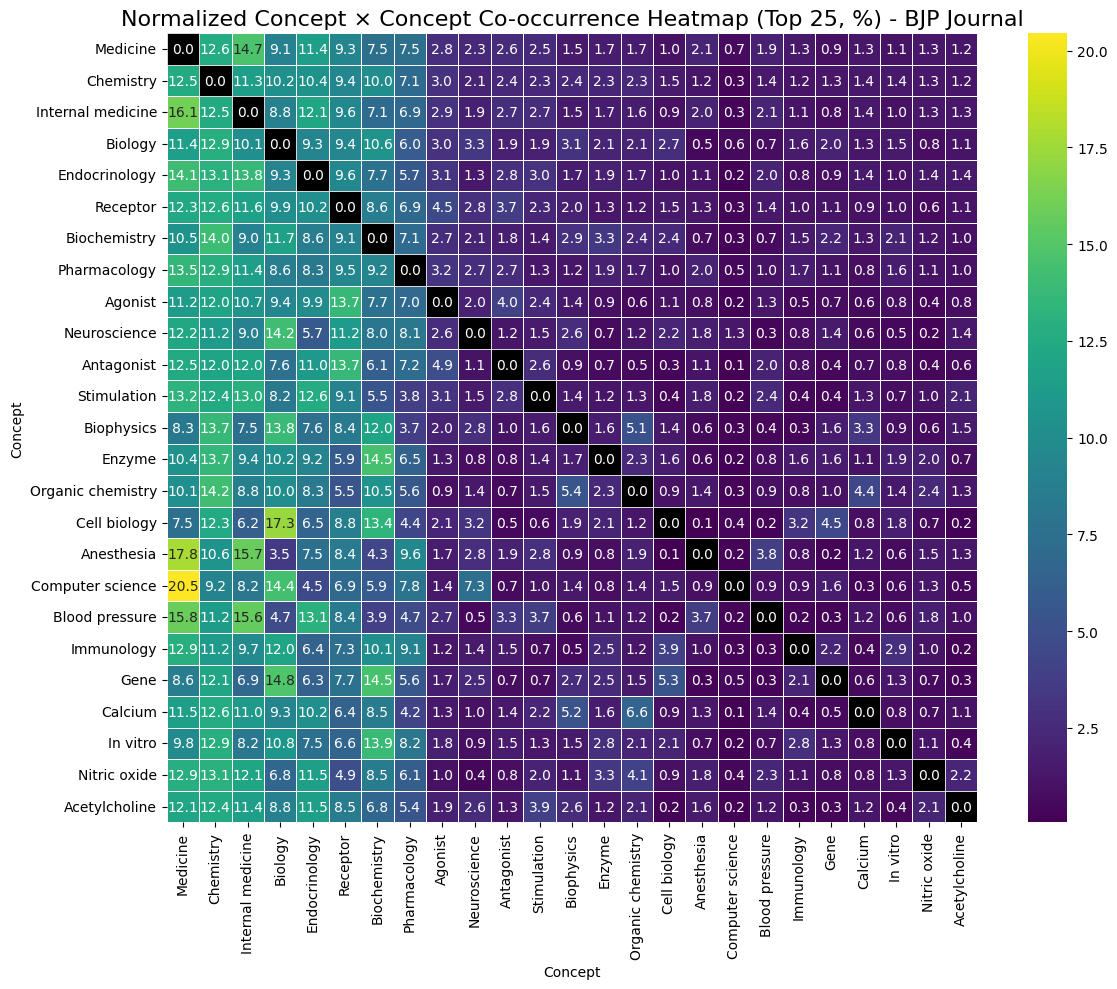

In [10]:

import itertools
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


concepts_par_work = [
    [c["display_name"] for c in ast.literal_eval(x)] if x not in [None, ""] else []
    for x in works_bjp["concepts"]
]

cp_pair_counter = {}
cp_totals = {}

for cps in concepts_par_work:
    cps = list(set(cps))  
    for c in cps:
        cp_totals[c] = cp_totals.get(c, 0) + 1
    if len(cps) >= 2:
        for pair in itertools.combinations(sorted(cps), 2):
            cp_pair_counter[pair] = cp_pair_counter.get(pair, 0) + 1

top_concepts = sorted(cp_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_concepts = [c for c, _ in top_concepts]

heatmap_cp = pd.DataFrame(0, index=top_concepts, columns=top_concepts, dtype=float)

for (c1, c2), count in cp_pair_counter.items():
    if c1 in top_concepts and c2 in top_concepts:
        heatmap_cp.loc[c1, c2] = count
        heatmap_cp.loc[c2, c1] = count

for c in top_concepts:
    row_sum = heatmap_cp.loc[c, :].sum()
    if row_sum > 0:
        heatmap_cp.loc[c, :] = heatmap_cp.loc[c, :] / row_sum * 100

plt.figure(figsize=(12,10))

mask = (heatmap_cp == 0)

ax = sns.heatmap(
    heatmap_cp,
    cmap="viridis",
    annot=True,
    fmt=".1f",
    mask=mask,
    linewidths=0.5,
    linecolor="white"
)


for i in range(heatmap_cp.shape[0]):
    for j in range(heatmap_cp.shape[1]):
        if heatmap_cp.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")


plt.title("Normalized Concept × Concept Co-occurrence Heatmap (Top 25, %) - BJP Journal", fontsize=16 )
plt.xlabel("Concept")
plt.ylabel("Concept")
plt.tight_layout()
plt.show()

C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\109317245.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


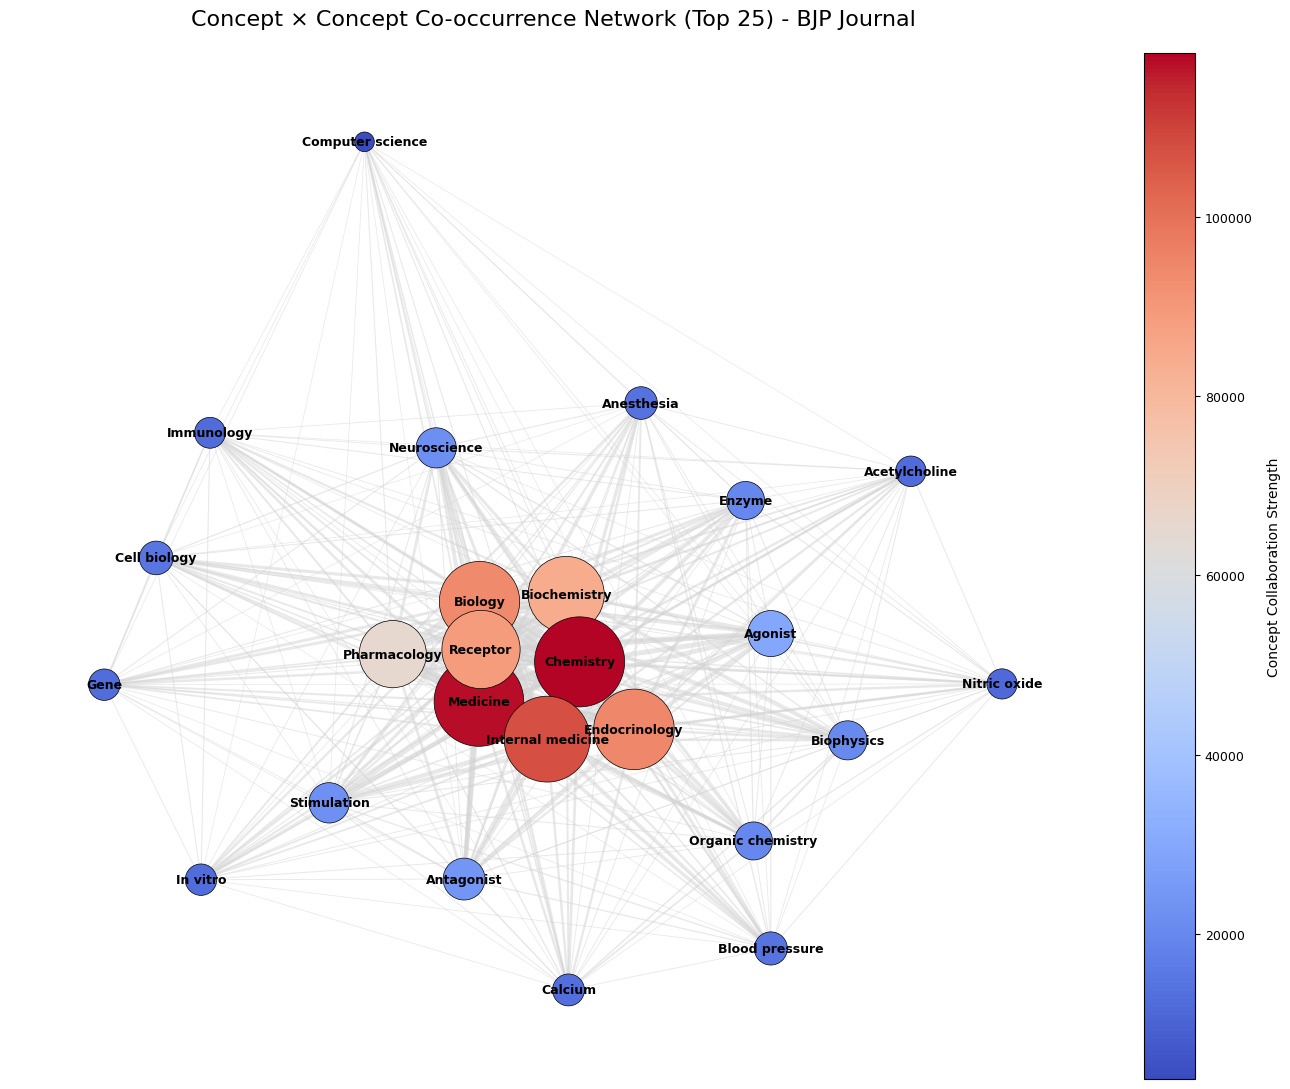

In [11]:
G_cp = nx.Graph()

for (c1, c2), count in cp_pair_counter.items():
    if c1 in top_concepts and c2 in top_concepts:
        G_cp.add_edge(c1, c2, weight=count)

node_vals = np.array([G_cp.degree(n, weight='weight') for n in G_cp.nodes()])
node_sizes = 200 + (node_vals - node_vals.min())/(node_vals.max()-node_vals.min()+1e-9)*4000

cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
node_colors = cmap(norm(node_vals))

edge_vals = np.array([G_cp[u][v]['weight'] for u,v in G_cp.edges()])
edge_widths = 0.5 + (edge_vals-edge_vals.min())/(edge_vals.max()-edge_vals.min()+1e-9)*15


pos = nx.spring_layout(G_cp, k=1.2, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(
    G_cp, pos,
    ax=ax,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.5
)

nx.draw_networkx_nodes(
    G_cp, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.5
)

nx.draw_networkx_labels(
    G_cp, pos,
    ax=ax,
    font_size=9,
    font_weight="bold"
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Concept Collaboration Strength", fontsize=10, labelpad=10)


ax.set_title("Concept × Concept Co-occurrence Network (Top 25) - BJP Journal", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()




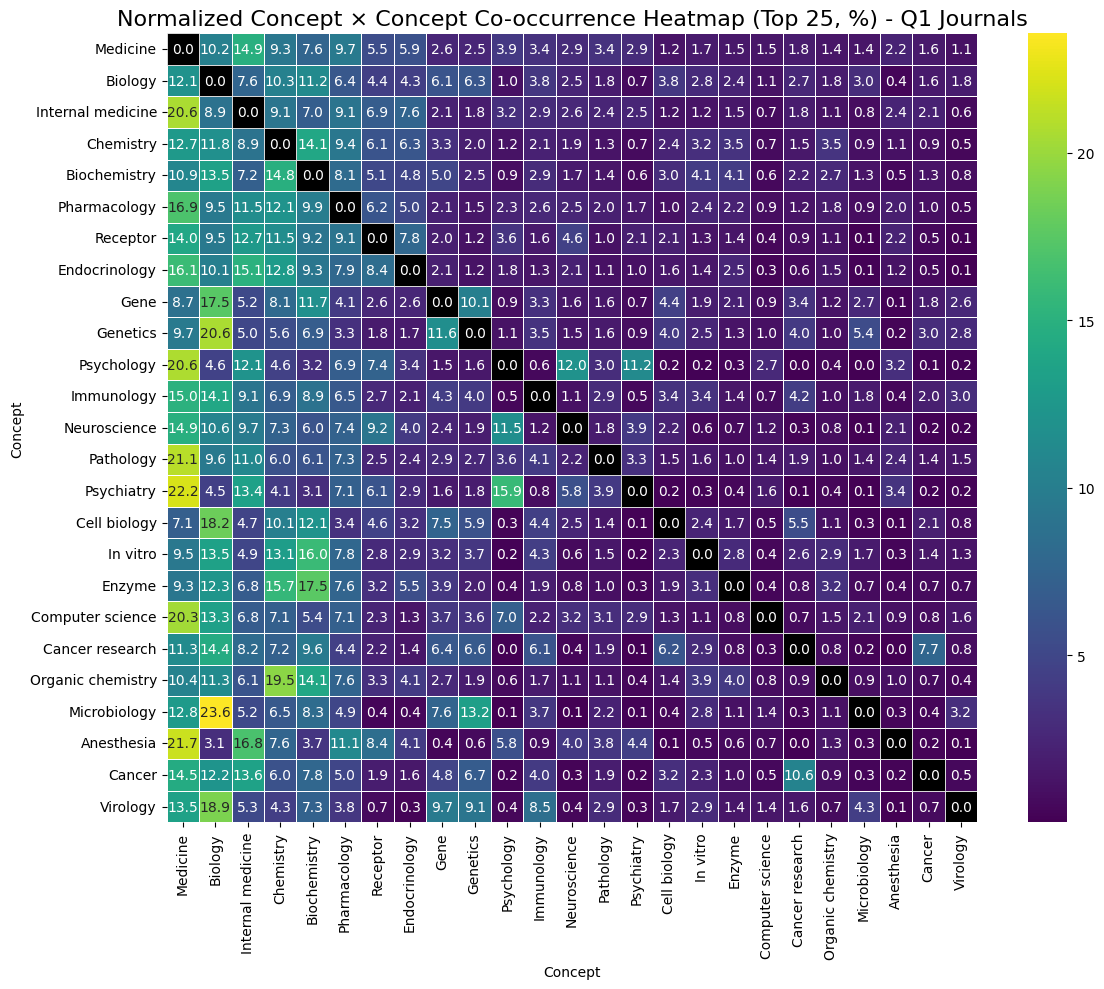

In [12]:
concepts_par_work = [
    [c["display_name"] for c in ast.literal_eval(x)] if x not in [None, ""] else []
    for x in works["concepts"]
]

cp_pair_counter = {}
cp_totals = {}

for cps in concepts_par_work:
    cps = list(set(cps))  
    for c in cps:
        cp_totals[c] = cp_totals.get(c, 0) + 1
    if len(cps) >= 2:
        for pair in itertools.combinations(sorted(cps), 2):
            cp_pair_counter[pair] = cp_pair_counter.get(pair, 0) + 1

top_concepts = sorted(cp_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_concepts = [c for c, _ in top_concepts]

heatmap_cp = pd.DataFrame(0, index=top_concepts, columns=top_concepts, dtype=float)

for (c1, c2), count in cp_pair_counter.items():
    if c1 in top_concepts and c2 in top_concepts:
        heatmap_cp.loc[c1, c2] = count
        heatmap_cp.loc[c2, c1] = count

for c in top_concepts:
    row_sum = heatmap_cp.loc[c, :].sum()
    if row_sum > 0:
        heatmap_cp.loc[c, :] = heatmap_cp.loc[c, :] / row_sum * 100

plt.figure(figsize=(12,10))

mask = (heatmap_cp == 0)

ax = sns.heatmap(
    heatmap_cp,
    cmap="viridis",
    annot=True,
    fmt=".1f",
    mask=mask,
    linewidths=0.5,
    linecolor="white"
)


for i in range(heatmap_cp.shape[0]):
    for j in range(heatmap_cp.shape[1]):
        if heatmap_cp.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")


plt.title("Normalized Concept × Concept Co-occurrence Heatmap (Top 25, %) - Q1 Journals", fontsize=16 )
plt.xlabel("Concept")
plt.ylabel("Concept")
plt.tight_layout()
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\4111833568.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


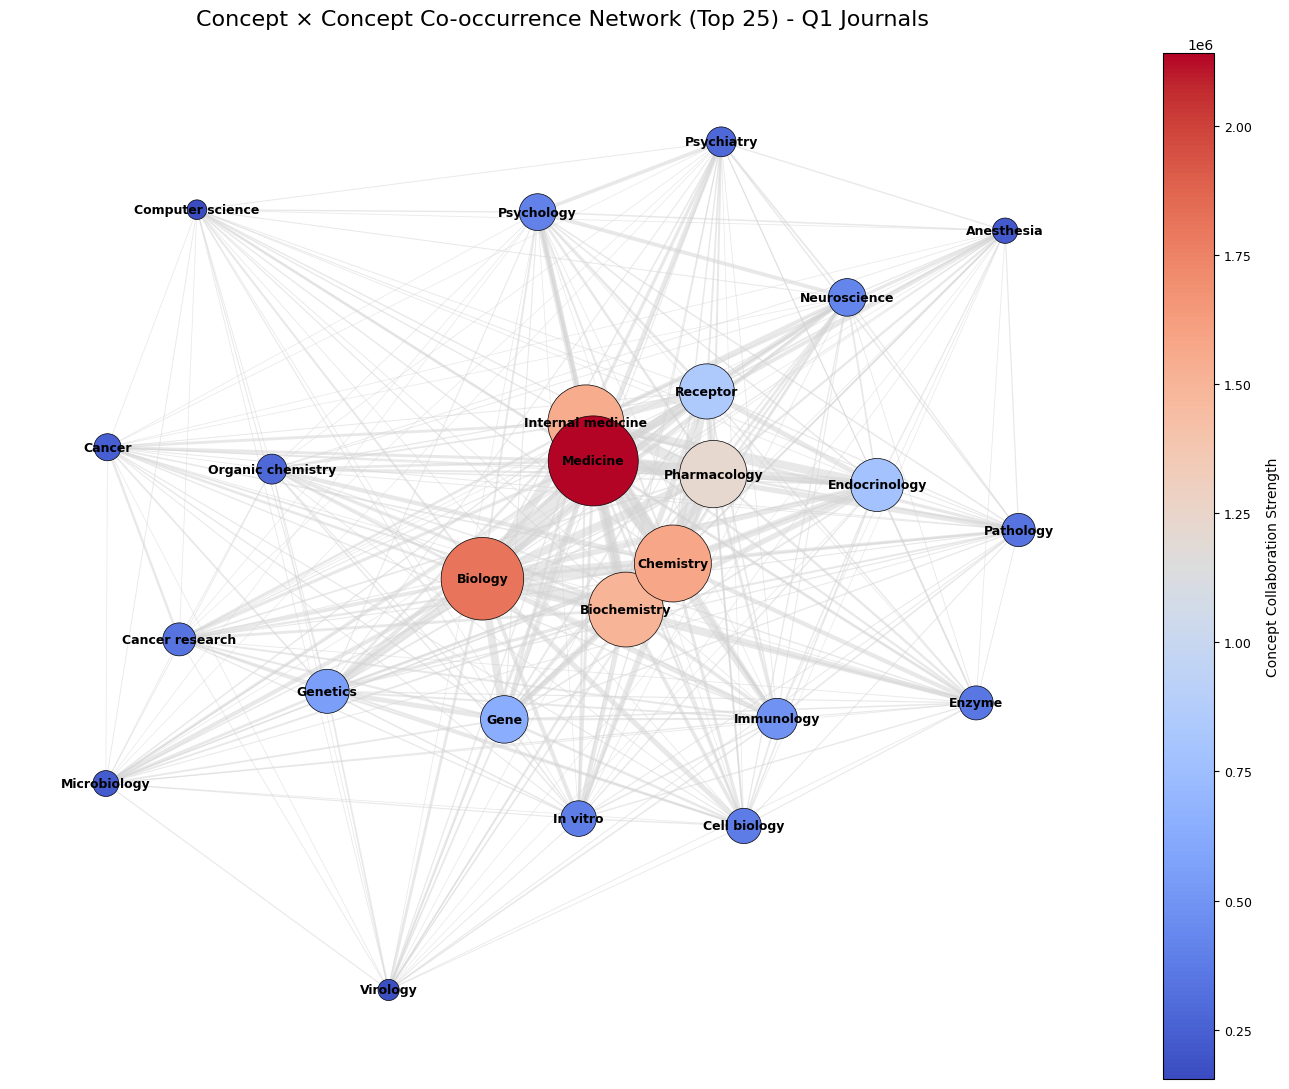

In [13]:
G_cp = nx.Graph()

for (c1, c2), count in cp_pair_counter.items():
    if c1 in top_concepts and c2 in top_concepts:
        G_cp.add_edge(c1, c2, weight=count)

node_vals = np.array([G_cp.degree(n, weight='weight') for n in G_cp.nodes()])
node_sizes = 200 + (node_vals - node_vals.min())/(node_vals.max()-node_vals.min()+1e-9)*4000

cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
node_colors = cmap(norm(node_vals))

edge_vals = np.array([G_cp[u][v]['weight'] for u,v in G_cp.edges()])
edge_widths = 0.5 + (edge_vals-edge_vals.min())/(edge_vals.max()-edge_vals.min()+1e-9)*15


pos = nx.spring_layout(G_cp, k=1.2, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(
    G_cp, pos,
    ax=ax,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.5
)

nx.draw_networkx_nodes(
    G_cp, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.5
)

nx.draw_networkx_labels(
    G_cp, pos,
    ax=ax,
    font_size=9,
    font_weight="bold"
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Concept Collaboration Strength", fontsize=10, labelpad=10)


ax.set_title("Concept × Concept Co-occurrence Network (Top 25) - Q1 Journals", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()




In [14]:
def prepare_keywords_top20_norm(df):
    parsed = [
        [k["display_name"] for k in ast.literal_eval(x)] if x not in [None, ""] else []
        for x in df["keywords"].to_list()
    ]

    keywords = pl.Series("keyword", list(chain.from_iterable(parsed)))
    citations = pl.Series(
        "cited_by_count",
        list(chain.from_iterable(
            [[c] * len(p) for c, p in zip(df["cited_by_count"].to_list(), parsed)]
        ))
    )
    
    mncs = pl.Series(
        "mncs",
        list(chain.from_iterable(
            [[m] * len(p) for m, p in zip(df["mncs"].to_list(), parsed)]
        ))
    )

    exploded = pl.DataFrame({"keyword": keywords, "cited_by_count": citations, "mncs": mncs})

    df_top20 = (
        exploded
        .group_by("keyword")
        .agg([
            pl.len().alias("n_articles"),
            pl.mean("mncs").alias("mean_mncs"),
            pl.sum("cited_by_count").alias("total_citations")
        ])
        .sort("n_articles", descending=True)
        .head(20)
        .to_pandas()
    )

    df_top20["mean_mncs_norm"] = df_top20["mean_mncs"] / df_top20["mean_mncs"].max()
    df_top20["n_articles_norm"] = df_top20["n_articles"] / df_top20["n_articles"].max()
    df_top20["total_citations_norm"] = df_top20["total_citations"] / df_top20["total_citations"].max()

    return df_top20


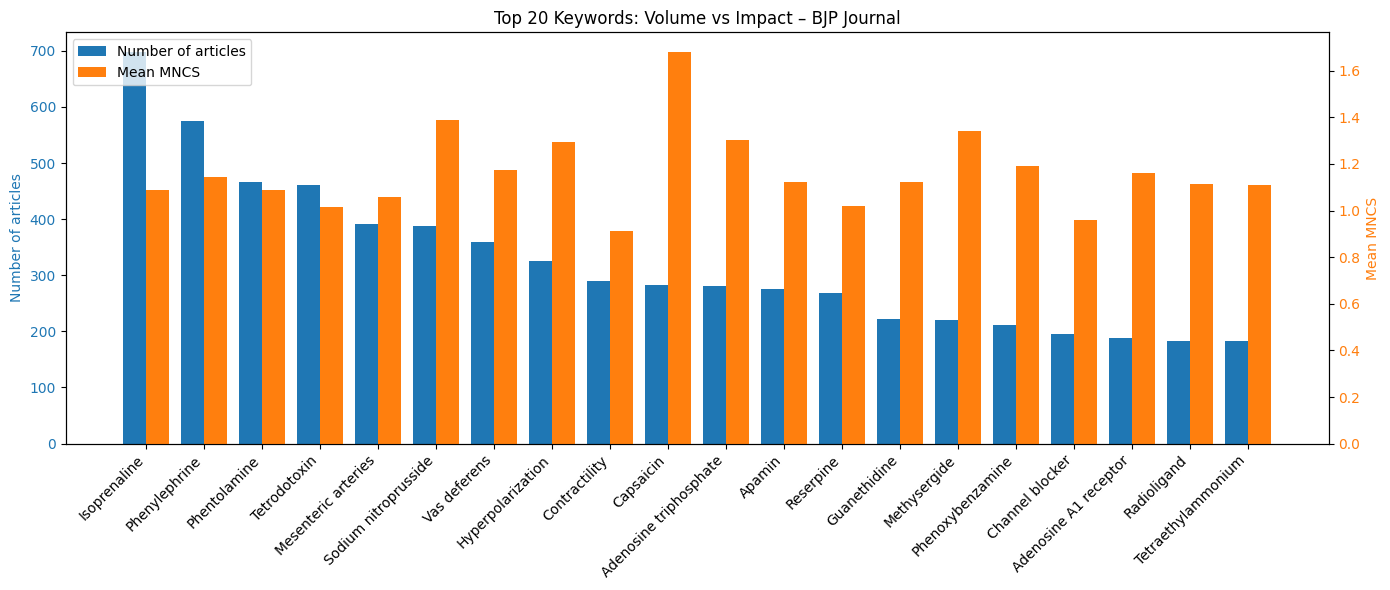

In [15]:
top_keywords_bjp = prepare_keywords_top20_norm(works_bjp)

x = np.arange(len(top_keywords_bjp))
width = 0.4

fig, ax1 = plt.subplots(figsize=(14, 6))

color_articles = "tab:blue"
color_mncs = "tab:orange"

bars1 = ax1.bar(
    x - width/2,
    top_keywords_bjp["n_articles"],
    width=width,
    color=color_articles,
    label="Number of articles"
)

ax1.set_ylabel("Number of articles", color=color_articles)
ax1.tick_params(axis="y", labelcolor=color_articles)

ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2,
    top_keywords_bjp["mean_mncs"],
    width=width,
    color=color_mncs,
    label="Mean MNCS"
)

ax2.set_ylabel("Mean MNCS", color=color_mncs)
ax2.tick_params(axis="y", labelcolor=color_mncs)

ax1.set_xticks(x)
ax1.set_xticklabels(
    top_keywords_bjp["keyword"],
    rotation=45,
    ha="right"
)

plt.title("Top 20 Keywords: Volume vs Impact – BJP Journal")

ax1.legend(
    handles=[bars1, bars2],
    labels=["Number of articles", "Mean MNCS"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


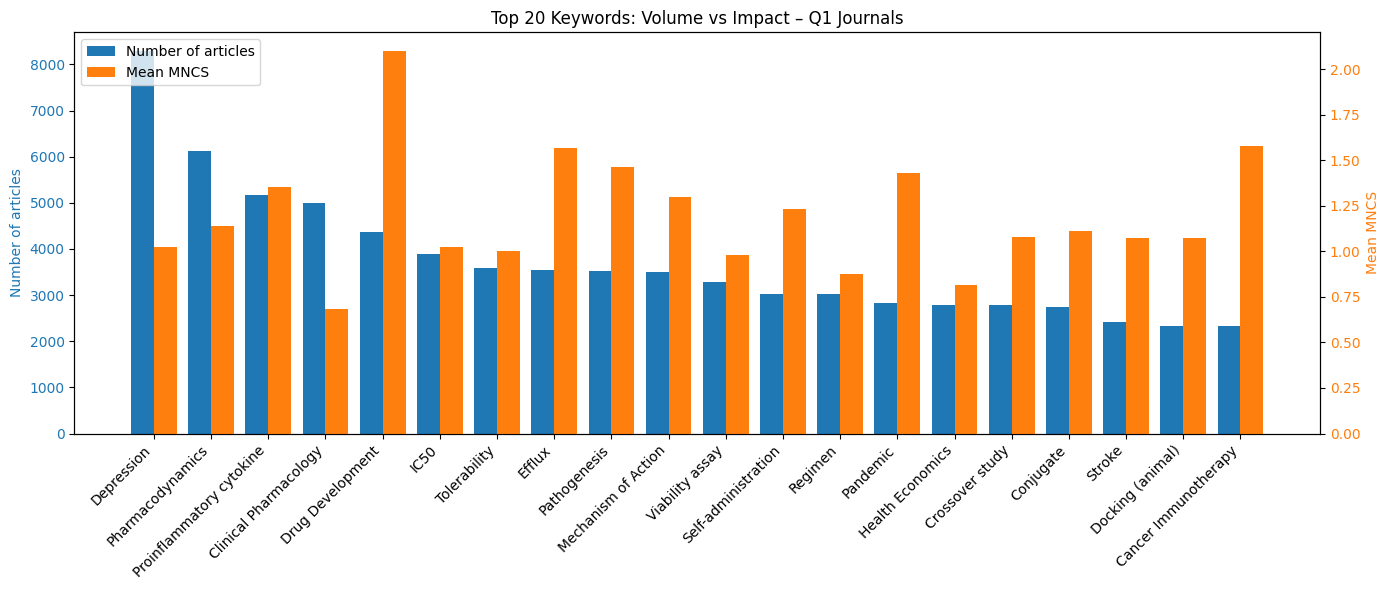

In [16]:
top_keywords = prepare_keywords_top20_norm(works)

x = np.arange(len(top_keywords))
width = 0.4

fig, ax1 = plt.subplots(figsize=(14, 6))

color_articles = "tab:blue"
color_mncs = "tab:orange"

bars1 = ax1.bar(
    x - width/2,
    top_keywords["n_articles"],
    width=width,
    color=color_articles,
    label="Number of articles"
)

ax1.set_ylabel("Number of articles", color=color_articles)
ax1.tick_params(axis="y", labelcolor=color_articles)

ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2,
    top_keywords["mean_mncs"],
    width=width,
    color=color_mncs,
    label="Mean MNCS"
)

ax2.set_ylabel("Mean MNCS", color=color_mncs)
ax2.tick_params(axis="y", labelcolor=color_mncs)

ax1.set_xticks(x)
ax1.set_xticklabels(
    top_keywords["keyword"],
    rotation=45,
    ha="right"
)

plt.title("Top 20 Keywords: Volume vs Impact – Q1 Journals")

ax1.legend(
    handles=[bars1, bars2],
    labels=["Number of articles", "Mean MNCS"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


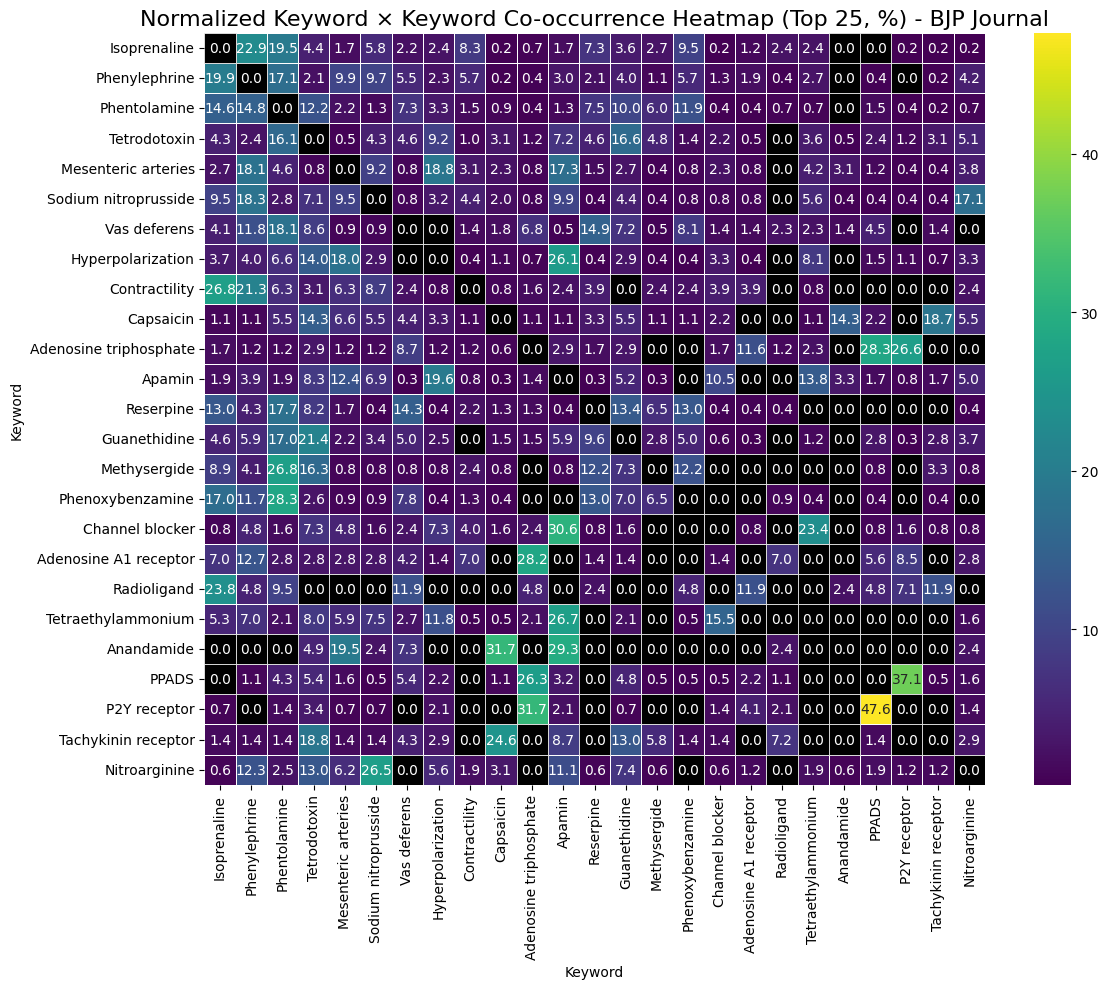

In [17]:

keywords_par_work = [
    [k["display_name"] for k in ast.literal_eval(x)] if x not in [None, ""] else []
    for x in works_bjp["keywords"]
]

kw_pair_counter = {}
kw_totals = {}

for kws in keywords_par_work:
    kws = list(set(kws))  
    for k in kws:
        kw_totals[k] = kw_totals.get(k, 0) + 1
    if len(kws) >= 2:
        for pair in itertools.combinations(sorted(kws), 2):
            kw_pair_counter[pair] = kw_pair_counter.get(pair, 0) + 1

top_keywords = sorted(kw_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_keywords = [k for k, _ in top_keywords]

heatmap_kw = pd.DataFrame(0, index=top_keywords, columns=top_keywords, dtype=float)

for (k1, k2), count in kw_pair_counter.items():
    if k1 in top_keywords and k2 in top_keywords:
        heatmap_kw.loc[k1, k2] = count
        heatmap_kw.loc[k2, k1] = count

for k in top_keywords:
    row_sum = heatmap_kw.loc[k, :].sum()
    if row_sum > 0:
        heatmap_kw.loc[k, :] = heatmap_kw.loc[k, :] / row_sum * 100

plt.figure(figsize=(12,10))

mask = (heatmap_kw == 0)

ax = sns.heatmap(
    heatmap_kw,
    cmap="viridis",
    annot=True,
    fmt=".1f",
    mask=mask,
    linewidths=0.5,
    linecolor="white"
)


for i in range(heatmap_kw.shape[0]):
    for j in range(heatmap_kw.shape[1]):
        if heatmap_kw.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")


plt.title("Normalized Keyword × Keyword Co-occurrence Heatmap (Top 25, %) - BJP Journal", fontsize=16 )
plt.xlabel("Keyword")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\3847122220.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


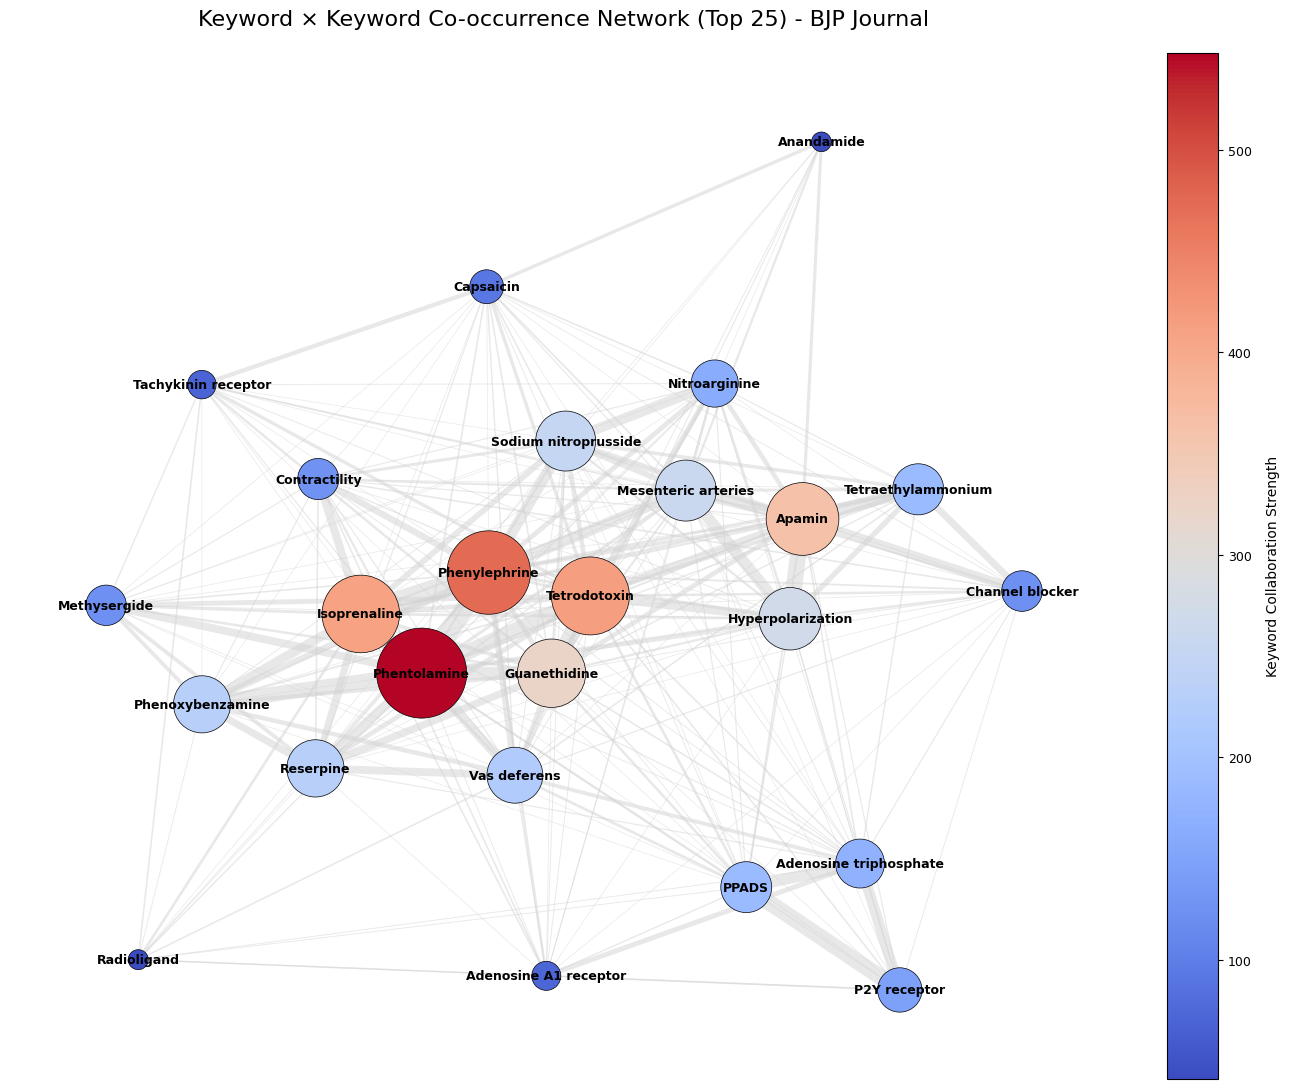

In [18]:
G_kw = nx.Graph()

for (k1, k2), count in kw_pair_counter.items():
    if k1 in top_keywords and k2 in top_keywords:
        G_kw.add_edge(k1, k2, weight=count)

node_vals = np.array([G_kw.degree(n, weight='weight') for n in G_kw.nodes()])
node_sizes = 200 + (node_vals - node_vals.min())/(node_vals.max()-node_vals.min()+1e-9)*4000

cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
node_colors = cmap(norm(node_vals))

edge_vals = np.array([G_kw[u][v]['weight'] for u,v in G_kw.edges()])
edge_widths = 0.5 + (edge_vals-edge_vals.min())/(edge_vals.max()-edge_vals.min()+1e-9)*15


pos = nx.spring_layout(G_kw, k=1.2, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(
    G_kw, pos,
    ax=ax,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.5
)

nx.draw_networkx_nodes(
    G_kw, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.5
)

nx.draw_networkx_labels(
    G_kw, pos,
    ax=ax,
    font_size=9,
    font_weight="bold"
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Keyword Collaboration Strength", fontsize=10, labelpad=10)


ax.set_title("Keyword × Keyword Co-occurrence Network (Top 25) - BJP Journal", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()




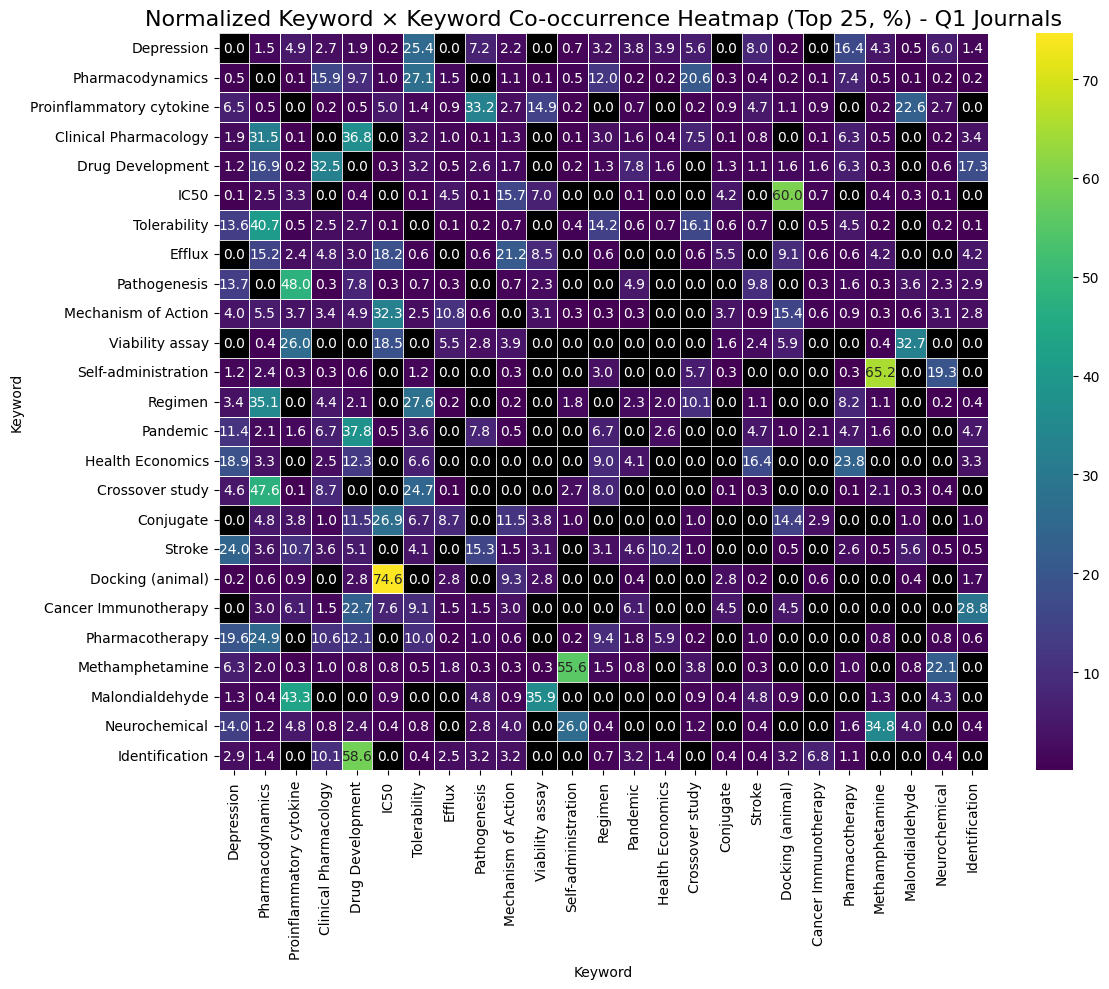

In [19]:

keywords_par_work = [
    [k["display_name"] for k in ast.literal_eval(x)] if x not in [None, ""] else []
    for x in works["keywords"]
]

kw_pair_counter = {}
kw_totals = {}

for kws in keywords_par_work:
    kws = list(set(kws))   
    for k in kws:
        kw_totals[k] = kw_totals.get(k, 0) + 1
    if len(kws) >= 2:
        for pair in itertools.combinations(sorted(kws), 2):
            kw_pair_counter[pair] = kw_pair_counter.get(pair, 0) + 1

top_keywords = sorted(kw_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_keywords = [k for k, _ in top_keywords]

heatmap_kw = pd.DataFrame(0, index=top_keywords, columns=top_keywords, dtype=float)

for (k1, k2), count in kw_pair_counter.items():
    if k1 in top_keywords and k2 in top_keywords:
        heatmap_kw.loc[k1, k2] = count
        heatmap_kw.loc[k2, k1] = count

for c in top_keywords:
    row_sum = heatmap_kw.loc[c, :].sum()
    if row_sum > 0:
        heatmap_kw.loc[c, :] = heatmap_kw.loc[c, :] / row_sum * 100

plt.figure(figsize=(12,10))

mask = (heatmap_kw == 0)

ax = sns.heatmap(
    heatmap_kw,
    cmap="viridis",
    annot=True,
    fmt=".1f",
    mask=mask,
    linewidths=0.5,
    linecolor="white"
)


for i in range(heatmap_kw.shape[0]):
    for j in range(heatmap_kw.shape[1]):
        if heatmap_kw.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")


plt.title("Normalized Keyword × Keyword Co-occurrence Heatmap (Top 25, %) - Q1 Journals", fontsize=16 )
plt.xlabel("Keyword")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\1942668785.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


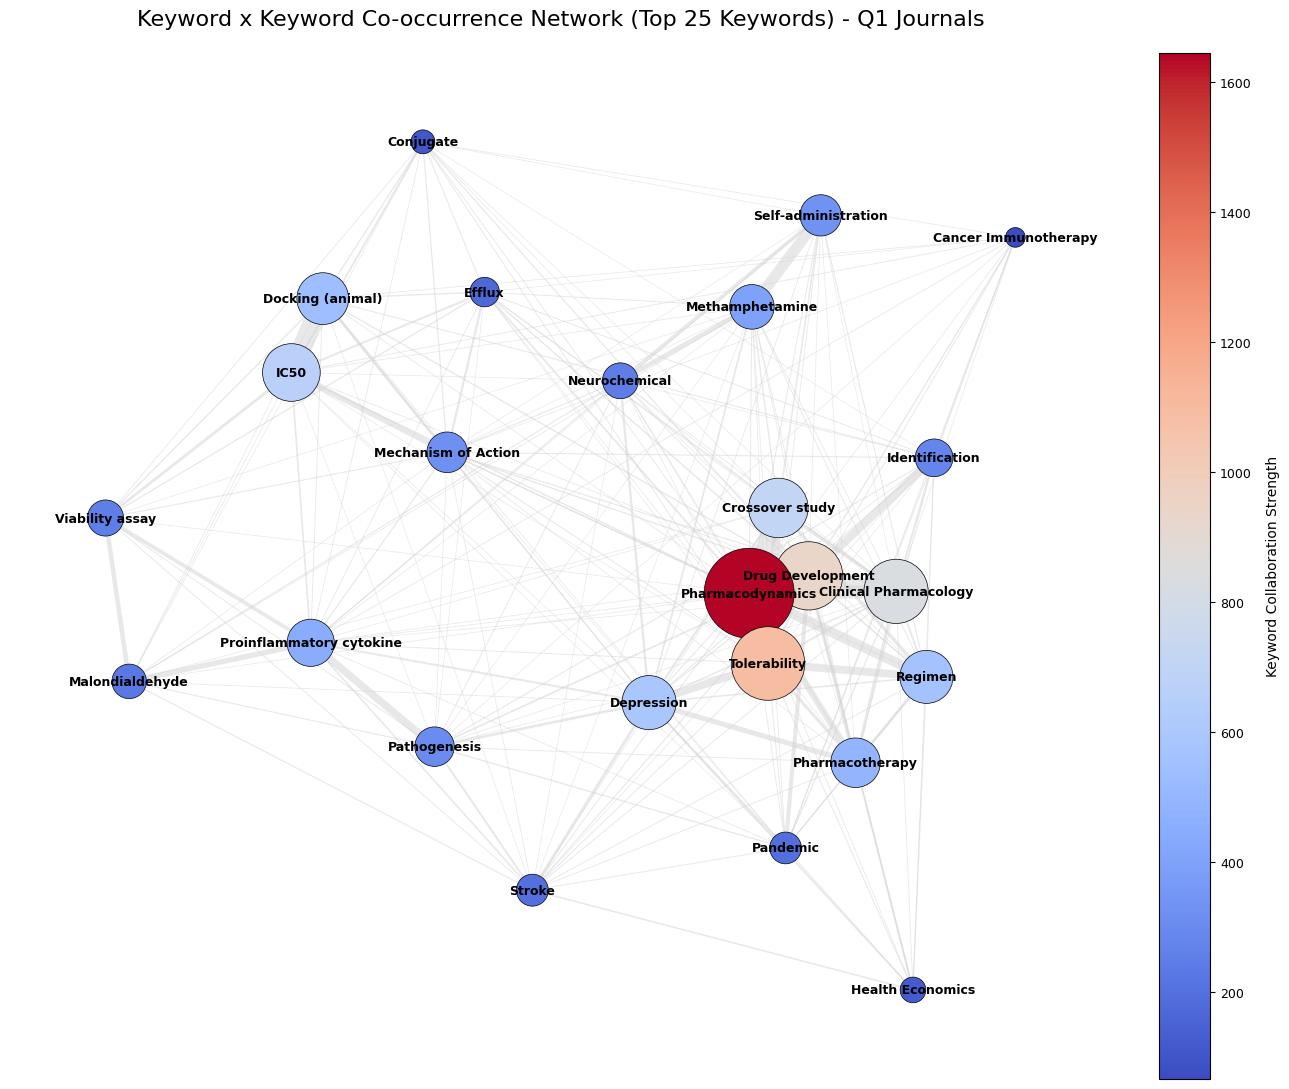

In [20]:
G_kw = nx.Graph()

for (k1, k2), count in kw_pair_counter.items():
    if k1 in top_keywords and k2 in top_keywords:
        G_kw.add_edge(k1, k2, weight=count)

node_vals = np.array([G_kw.degree(n, weight='weight') for n in G_kw.nodes()])
node_sizes = 200 + (node_vals - node_vals.min())/(node_vals.max()-node_vals.min()+1e-9)*4000

cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
node_colors = cmap(norm(node_vals))

edge_vals = np.array([G_kw[u][v]['weight'] for u,v in G_kw.edges()])
edge_widths = 0.5 + (edge_vals-edge_vals.min())/(edge_vals.max()-edge_vals.min()+1e-9)*15


pos = nx.spring_layout(G_kw, k=1.2, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(
    G_kw, pos,
    ax=ax,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.5
)

nx.draw_networkx_nodes(
    G_kw, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.5
)

nx.draw_networkx_labels(
    G_kw, pos,
    ax=ax,
    font_size=9,
    font_weight="bold"
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Keyword Collaboration Strength", fontsize=10, labelpad=10)


ax.set_title("Keyword x Keyword Co-occurrence Network (Top 25 Keywords) - Q1 Journals", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()




In [21]:
works_bjp = works_bjp.with_columns(
    primary_topic = pl.col("primary_topic").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_subfield = pl.col("primary_subfield").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_field = pl.col("primary_field").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True), 
    primary_domain = pl.col("primary_domain").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True)
)

works = works.with_columns(
    primary_topic = pl.col("primary_topic").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_subfield = pl.col("primary_subfield").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_field = pl.col("primary_field").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True), 
    primary_domain = pl.col("primary_domain").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True)
)

In [22]:
group_topics = (
    works
    .group_by("primary_topic")
    .agg([
        pl.count().alias("count"),  # nombre de publications
        pl.sum("cited_by_count").alias("cited_by_count"),  
        pl.mean("mncs").alias("mncs_mean")
    ])
    .sort("cited_by_count", descending=True)
)

group_topics_bjp = (
    works_bjp
    .group_by("primary_topic")
    .agg([
        pl.count().alias("count"), 
        pl.sum("cited_by_count").alias("cited_by_count"),
        pl.mean("mncs").alias("mncs_mean")
    ])
    .sort("cited_by_count", descending=True)
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\2373763334.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),  # nombre de publications
C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\2373763334.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


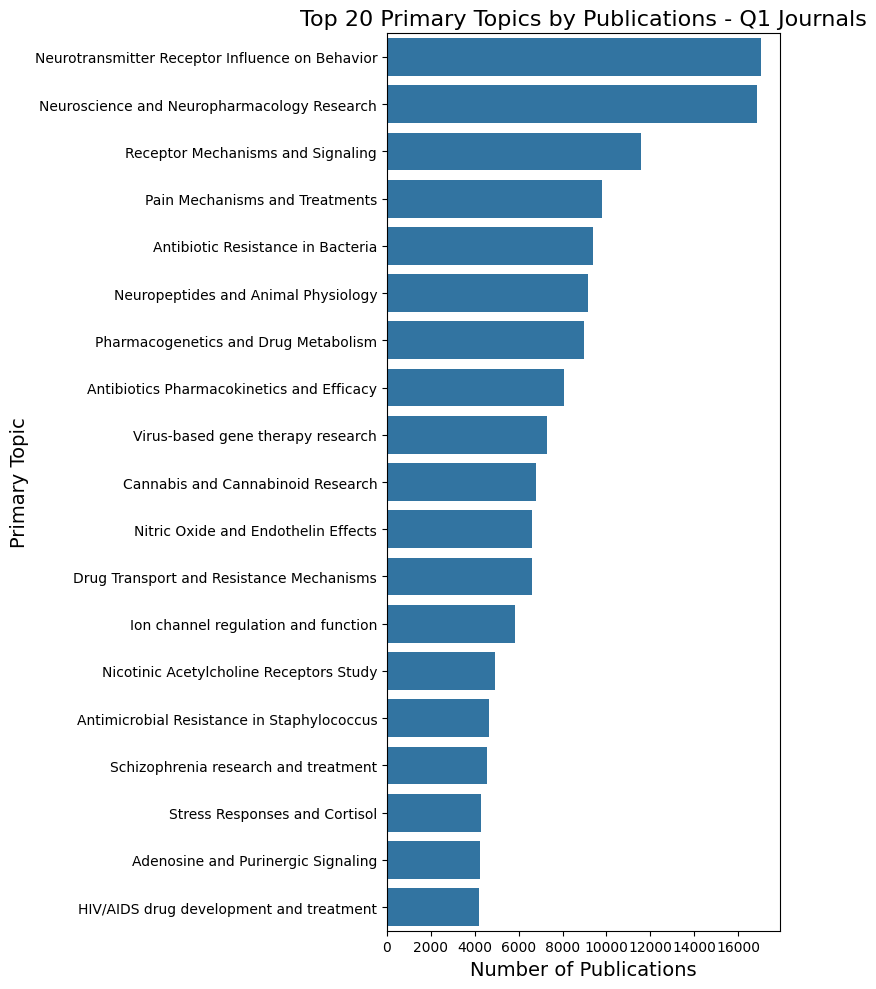

In [23]:
top20_topics = (
    group_topics
    .sort("count", descending = True)  
    .head(20)                              
)

aq.load_theme("scientific")

plt.figure(figsize=(8,10))
sns.barplot(
    data=top20_topics,
    x="count",
    y="primary_topic",
    orient="h"
)

plt.ylabel("Primary Topic", fontsize=14)
plt.xlabel("Number of Publications", fontsize=14)
plt.title("Top 20 Primary Topics by Publications - Q1 Journals", fontsize=16)
plt.tight_layout()
plt.show()


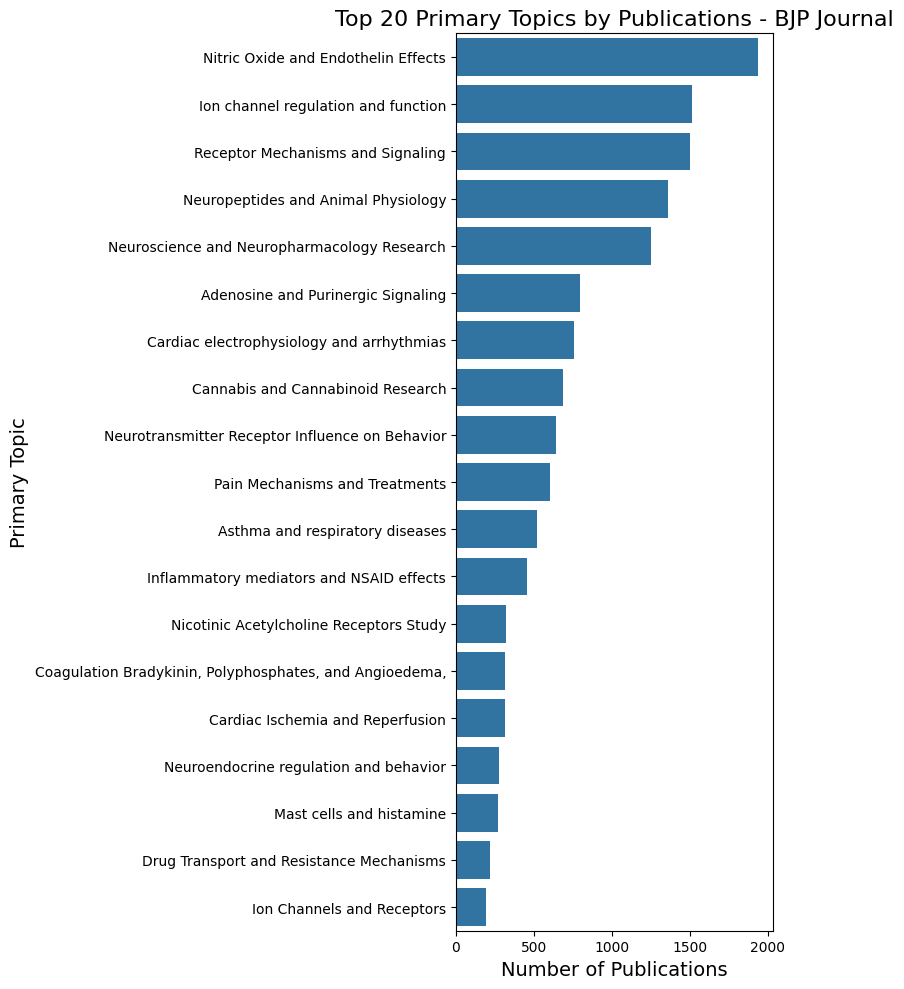

In [24]:
top20_topics = (
    group_topics_bjp
    .sort("count", descending = True) 
    .head(20)                              
)

aq.load_theme("scientific")

plt.figure(figsize=(8,10))
sns.barplot(
    data=top20_topics,
    x="count",
    y="primary_topic",
    orient="h"
)

plt.ylabel("Primary Topic", fontsize=14)
plt.xlabel("Number of Publications", fontsize=14)
plt.title("Top 20 Primary Topics by Publications - BJP Journal", fontsize=16)
plt.tight_layout()
plt.show()


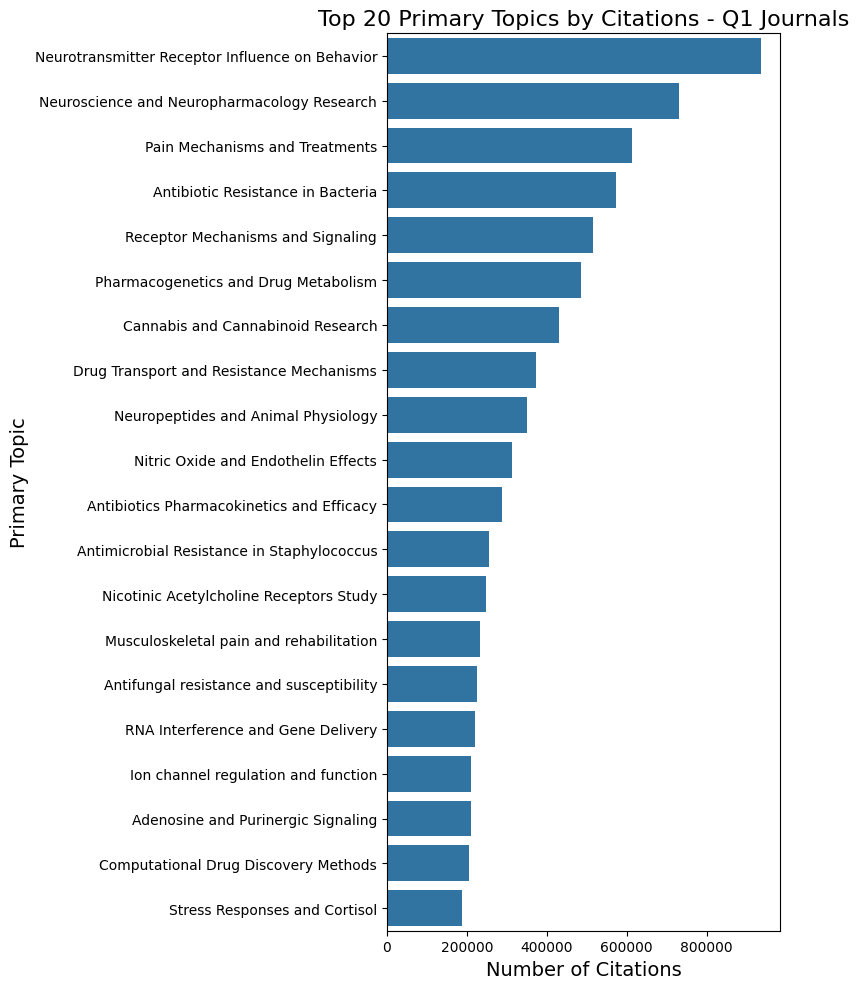

In [25]:
top20_topics = (
    group_topics
    .sort("cited_by_count", descending = True)  
    .head(20)                              
)

aq.load_theme("scientific")

plt.figure(figsize=(8,10))
sns.barplot(
    data=top20_topics,
    x="cited_by_count",
    y="primary_topic",
    orient="h"
)

plt.ylabel("Primary Topic", fontsize=14)
plt.xlabel("Number of Citations", fontsize=14)
plt.title("Top 20 Primary Topics by Citations - Q1 Journals", fontsize=16)
plt.tight_layout()
plt.show()


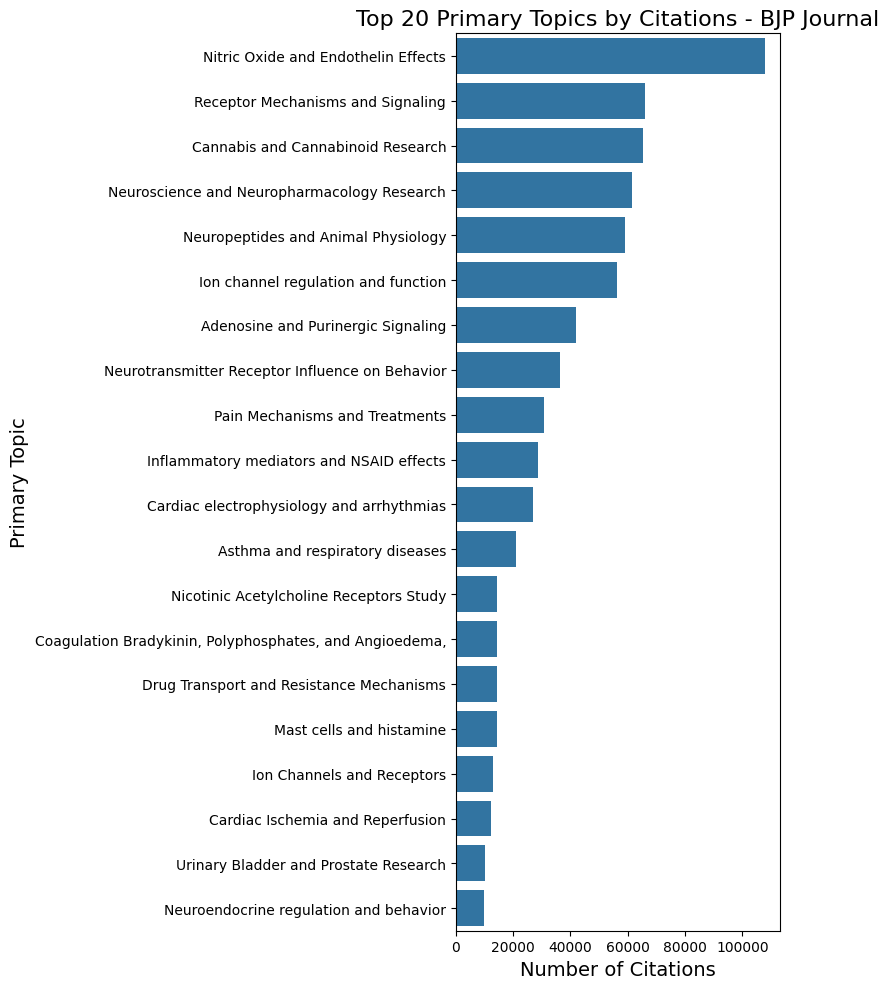

In [26]:
top20_topics = (
    group_topics_bjp
    .sort("cited_by_count", descending = True)  
    .head(20)                             
)

aq.load_theme("scientific")

plt.figure(figsize=(8,10))
sns.barplot(
    data=top20_topics,
    x="cited_by_count",
    y="primary_topic",
    orient="h"
)

plt.ylabel("Primary Topic", fontsize=14)
plt.xlabel("Number of Citations", fontsize=14)
plt.title("Top 20 Primary Topics by Citations - BJP Journal", fontsize=16)
plt.tight_layout()
plt.show()


In [29]:
from ajustText import adjust_text

top_20_topics = group_topics.head(20)


top_20_topics = top_20_topics.with_columns([
    pl.col("count").log().alias("publications_log"), 
])

top_20_topics = top_20_topics.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log"), 
)


pub_log = top_20_topics["publications_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = top_20_topics["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)



top_20_topics = top_20_topics.with_columns([
    ((pl.col("publications_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

plt.scatter(
    top_20_topics["x_viz"],
    top_20_topics["y_viz"],
    s=100,
    color='skyblue',
    edgecolor='k',
    zorder=2
)

texts = []
for name, x, y in zip(
    top_20_topics["primary_topic"],
    top_20_topics["x_viz"],
    top_20_topics["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    
    texts.append(plt.text(x, y, name, fontsize=10, fontweight="bold", color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=1))

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.plot(
    [-1.1, 1.1],
    [1.1, -1.1],
    color="black",
    linestyle="--",
    linewidth=1,
    zorder=1
)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("Top 20 Q1 Topics : Publications vs Mean MNCS")

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'ajustText'

In [ ]:
top_20_topics = group_topics_bjp.head(20)


top_20_topics = top_20_topics.with_columns([
    pl.col("count").log().alias("publications_log"), 
])

top_20_topics = top_20_topics.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log"),  
)


pub_log = top_20_topics["publications_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = top_20_topics["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)



top_20_topics = top_20_topics.with_columns([
    ((pl.col("publications_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

plt.scatter(
    top_20_topics["x_viz"],
    top_20_topics["y_viz"],
    s=100,
    color='skyblue',
    edgecolor='k',
    zorder=2
)

texts = []
for name, x, y in zip(
    top_20_topics["primary_topic"],
    top_20_topics["x_viz"],
    top_20_topics["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    
    texts.append(plt.text(x, y, name, fontsize=10, fontweight="bold", color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=1))

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.plot(
    [-1.1, 1.1],
    [1.1, -1.1],
    color="black",
    linestyle="--",
    linewidth=1,
    zorder=1
)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("Top 20 BJP Topics : Publications vs Mean MNCS")

plt.tight_layout()
plt.show()



C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\3729531524.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\3729531524.py:22: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("year").is_in(topics_counts["year"].unique()))
C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\3729531524.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("total_year"))


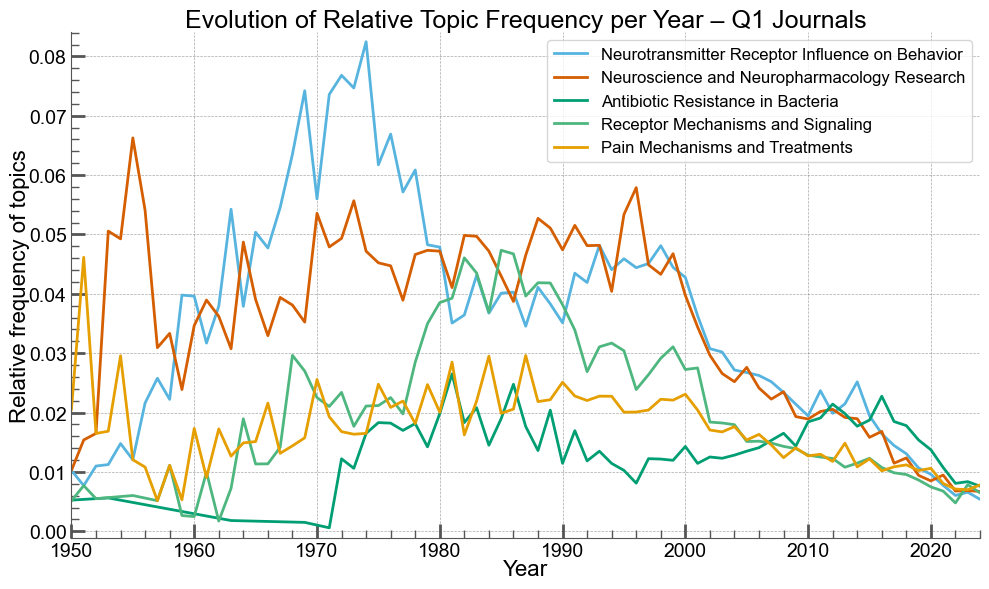

In [30]:
selected_topics = [
    "Neurotransmitter Receptor Influence on Behavior",
    "Neuroscience and Neuropharmacology Research",
    "Antibiotic Resistance in Bacteria",
    "Receptor Mechanisms and Signaling",
    "Pain Mechanisms and Treatments",
]

works_small = works.select(["year", "primary_topic"])
works_filtered = works_small.filter(pl.col("primary_topic").is_not_null())

topics_counts = (
    works_filtered
    .filter(pl.col("primary_topic").is_in(selected_topics))
    .group_by(["year", "primary_topic"])
    .agg(pl.count().alias("count"))
    .sort("year")
)

total_per_year = (
    works_filtered
    .filter(pl.col("year").is_in(topics_counts["year"].unique()))
    .group_by("year")
    .agg(pl.count().alias("total_year"))
    .sort("year")
)

topics_counts = topics_counts.join(total_per_year, on="year")
topics_counts = topics_counts.with_columns(
    (pl.col("count") / pl.col("total_year")).alias("frequency")
)

years = sorted(topics_counts["year"].unique().to_list())
topic_cols = selected_topics

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))

    for topic in topic_cols:
        df_topic = topics_counts.filter(pl.col("primary_topic") == topic)
        plt.plot(df_topic["year"].to_list(), df_topic["frequency"].to_list(), label=topic, linewidth=2)

    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Relative frequency of topics", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Evolution of Relative Topic Frequency per Year – Q1 Journals", fontsize=18)
    plt.xlim(min(years), max(years))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlim(1950, 2024)
    plt.tight_layout()
    plt.show()


In [ ]:
selected_topics = [
    "Nitric Oxide and Endothelin Effects",
    "Neuroscience and Neuropharmacology Research",
    "Cannabis and Cannabinoid Research",
    "Receptor Mechanisms and Signaling",
    "Neuropeptides and Animal Physiology",
]


works_small = works_bjp.select(["year", "primary_topic"])
works_filtered = works_small.filter(pl.col("primary_topic").is_not_null())

topics_counts = (
    works_filtered
    .filter(pl.col("primary_topic").is_in(selected_topics))
    .group_by(["year", "primary_topic"])
    .agg(pl.count().alias("count"))
    .sort("year")
)

total_per_year = (
    works_filtered
    .filter(pl.col("year").is_in(topics_counts["year"].unique()))
    .group_by("year")
    .agg(pl.count().alias("total_year"))
    .sort("year")
)

topics_counts = topics_counts.join(total_per_year, on="year")
topics_counts = topics_counts.with_columns(
    (pl.col("count") / pl.col("total_year")).alias("frequency")
)

years = sorted(topics_counts["year"].unique().to_list())
topic_cols = selected_topics

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))

    for topic in topic_cols:
        df_topic = topics_counts.filter(pl.col("primary_topic") == topic)
        plt.plot(df_topic["year"].to_list(), df_topic["frequency"].to_list(), label=topic, linewidth=2)

    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Relative frequency of topics", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Evolution of Relative Topic Frequency per Year – BJP Journal", fontsize=18)
    plt.xlim(min(years), max(years))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.xlim(1968, 2024)
    plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_2684\2758098388.py:17: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


<Figure size 640x480 with 0 Axes>

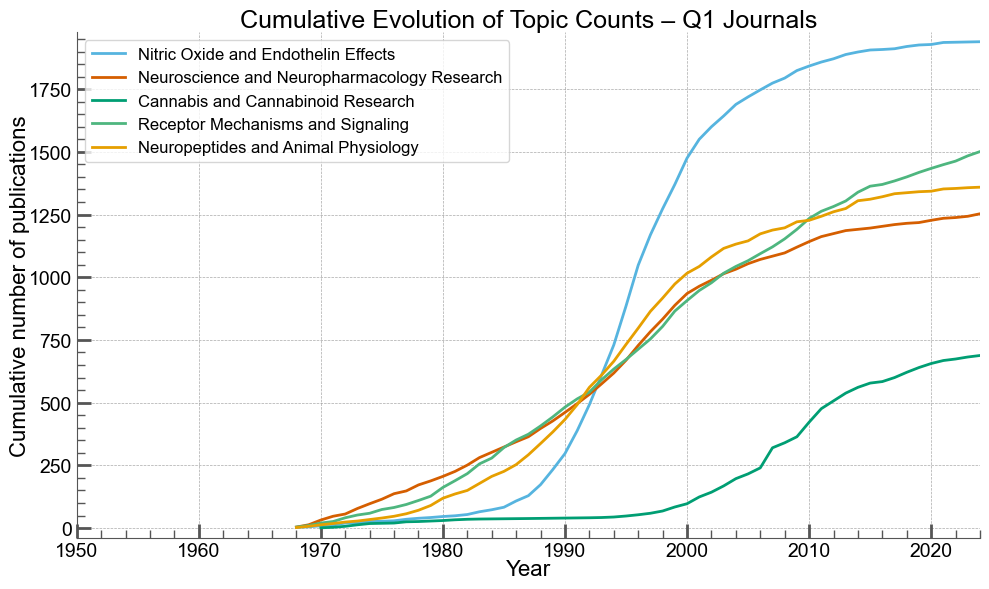

In [ ]:
selected_topics = [
    "Neurotransmitter Receptor Influence on Behavior",
    "Neuroscience and Neuropharmacology Research",
    "Antibiotic Resistance in Bacteria",
    "Receptor Mechanisms and Signaling",
    "Pain Mechanisms and Treatments",
]

works_small = works.select(["year", "primary_topic"])
works_filtered = works_small.filter(pl.col("primary_topic").is_not_null())

topics_counts = (
    works_filtered
    .filter(pl.col("primary_topic").is_in(selected_topics))
    .group_by(["year", "primary_topic"])
    .agg(pl.count().alias("count"))
    .sort(["primary_topic", "year"])
)

topics_counts = topics_counts.with_columns(
    pl.col("count")
    .cum_sum()
    .over("primary_topic")
    .alias("cumulative_count")
)

years = sorted(topics_counts["year"].unique().to_list())

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))

    for topic in selected_topics:
        df_topic = topics_counts.filter(pl.col("primary_topic") == topic)
        plt.plot(
            df_topic["year"].to_list(),
            df_topic["cumulative_count"].to_list(),
            label=topic,
            linewidth=2
        )

    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of publications", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Cumulative Evolution of Topic Counts – Q1 Journals", fontsize=18)
    plt.xlim(1950, 2024)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()



In [ ]:
selected_topics = [
    "Nitric Oxide and Endothelin Effects",
    "Neuroscience and Neuropharmacology Research",
    "Cannabis and Cannabinoid Research",
    "Receptor Mechanisms and Signaling",
    "Neuropeptides and Animal Physiology",
]


works_small = works_bjp.select(["year", "primary_topic"])
works_filtered = works_small.filter(pl.col("primary_topic").is_not_null())

topics_counts = (
    works_filtered
    .filter(pl.col("primary_topic").is_in(selected_topics))
    .group_by(["year", "primary_topic"])
    .agg(pl.count().alias("count"))
    .sort(["primary_topic", "year"])
)

topics_counts = topics_counts.with_columns(
    pl.col("count")
    .cum_sum()
    .over("primary_topic")
    .alias("cumulative_count")
)

years = sorted(topics_counts["year"].unique().to_list())

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))

    for topic in selected_topics:
        df_topic = topics_counts.filter(pl.col("primary_topic") == topic)
        plt.plot(
            df_topic["year"].to_list(),
            df_topic["cumulative_count"].to_list(),
            label=topic,
            linewidth=2
        )

    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of publications", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.title("Cumulative Evolution of Topic Counts – BJP Journal", fontsize=18)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlim(1968, 2024)
    plt.tight_layout()
    plt.show()


In [34]:
import wordcloud as wc

year_ranges = [
    (">= 2020", pl.col("year") >= 2020),
    ("2010 - 2019", (pl.col("year") >= 2010) & (pl.col("year") < 2020)),
    ("2000 - 2009", (pl.col("year") >= 2000) & (pl.col("year") < 2010)),
    ("1985 - 1999", (pl.col("year") >= 1985) & (pl.col("year") < 2000)),
    ("1968 - 1984", (pl.col("year") >= 1968) & (pl.col("year") < 1985)),
    ("1950 - 1967", (pl.col("year") >= 1950) & (pl.col("year") < 1968)),
]



stopwords_custom = ["Research", "Treatment", "Signaling", "Applications", 
                    "Mechanisms", "research", " s ", "Receptor", 
                    "function", "Studies","treatment","based","Study"]

for label, condition in year_ranges:
    works_new = works.filter(condition)

    primary_topics = (
        works_new
        .filter(pl.col("primary_topic").is_not_null())
        .select("primary_topic")
        .to_series()
        .to_list()
    )

    text = " ".join(primary_topics)
    for word in stopwords_custom:
        text = text.replace(word, "")


    wordcloud = wc.WordCloud(background_color="white", width= 2000, height= 1000).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topics {label}", fontsize=16)
    plt.axis("off")
    
    savelabel = '2020_2024' if label == '>= 2020' else label.replace(" - ", "_").replace(">= ", "").replace(" ", "")
    plt.savefig(
    f"../results/q1/topics/best_topics_{savelabel}.png", #change 
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.05
    )

    plt.show()


KeyboardInterrupt: 

In [ ]:


year_ranges = [
    (">= 2020", pl.col("year") >= 2020),
    ("2010 - 2019", (pl.col("year") >= 2010) & (pl.col("year") < 2020)),
    ("2000 - 2009", (pl.col("year") >= 2000) & (pl.col("year") < 2010)),
    ("1985 - 1999", (pl.col("year") >= 1985) & (pl.col("year") < 2000)),
    ("1968 - 1984", (pl.col("year") >= 1968) & (pl.col("year") < 1985)),
]



stopwords_custom = ["Research", "Treatment", "Signaling", "Applications", 
                    "Mechanisms", "research", " s ", "Receptor", 
                    "function", "Studies","treatment","based","Study"]

for label, condition in year_ranges:
    works_new = works_bjp.filter(condition)

    primary_topics = (
        works_new
        .filter(pl.col("primary_topic").is_not_null())
        .select("primary_topic")
        .to_series()
        .to_list()
    )

    text = " ".join(primary_topics)
    for word in stopwords_custom:
        text = text.replace(word, "")


    wordcloud = wc.WordCloud(background_color="white", width= 2000, height= 1000).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topics {label}", fontsize=16)
    plt.axis("off")
    
    savelabel = '2020_2024' if label == '>= 2020' else label.replace(" - ", "_").replace(">= ", "").replace(" ", "")
    plt.savefig(
    f"../results/bjp/topics/best_topics_{savelabel}.png", #change
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.05
    )

    plt.show()

In [ ]:

"""import os
output_dir = "../../../data/vosviewer"


for label, condition in year_ranges:
    works_period = works.filter(condition).filter(pl.col("primary_topic").is_not_null())

    primary_topics = works_period.select("primary_topic").to_series().to_list()
    cleaned_topics = []
    for topic in primary_topics:
        topic_clean = str(topic)
        for word in stopwords_custom:
            topic_clean = topic_clean.replace(word, "")
        topic_clean = topic_clean.strip()  
        if topic_clean: 
            cleaned_topics.append(topic_clean)



    df_cleaned = pl.DataFrame({"Title": cleaned_topics})

    safe_label = label.replace(" ", "").replace(">=", "_sup")
    output_path = os.path.join(output_dir, f"topics{safe_label}.csv")

    df_cleaned.write_csv(output_path)

    print(f"File created : {output_path} ({len(cleaned_topics)} lines)")"""


In [ ]:

"""import os
output_dir = "../../../data/vosviewer"


for label, condition in year_ranges:
    works_period = works_bjp.filter(condition).filter(pl.col("primary_topic").is_not_null())

    primary_topics = works_period.select("primary_topic").to_series().to_list()
    cleaned_topics = []
    for topic in primary_topics:
        topic_clean = str(topic)
        for word in stopwords_custom:
            topic_clean = topic_clean.replace(word, "")
        topic_clean = topic_clean.strip()  
        if topic_clean: 
            cleaned_topics.append(topic_clean)



    df_cleaned = pl.DataFrame({"Title": cleaned_topics})

    safe_label = label.replace(" ", "").replace(">=", "_sup")
    output_path = os.path.join(output_dir, f"topics_bjp_{safe_label}.csv")

    df_cleaned.write_csv(output_path)

    print(f"File created : {output_path} ({len(cleaned_topics)} lines)")"""


In [ ]:
import bar_chart_race as bcr


topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([
        pl.count("title").alias("n")  
    ])
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)

topics_pivot_pd = topics_pivot.to_pandas().set_index("year")

topics_pivot_pd = topics_pivot_pd.cumsum()


topics_pivot_pd.index = pd.PeriodIndex(topics_pivot_pd.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd,
    filename='q1_topics_over_time.mp4',  
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the Top Q1 Topics Over Time',
    bar_size=.95,
    interpolate_period=True
)


In [ ]:
import bar_chart_race as bcr


topics_pivot = (
    works_bjp
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([
        pl.count("title").alias("n")  
    ])
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)

topics_pivot_pd = topics_pivot.to_pandas().set_index("year")

topics_pivot_pd = topics_pivot_pd.cumsum()


topics_pivot_pd.index = pd.PeriodIndex(topics_pivot_pd.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd,
    filename='bjp_topics_over_time.mp4',  
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the Top BJP Topics Over Time',
    bar_size=.95,
    interpolate_period=True
)


In [ ]:
smoothing = 5
start_year = 1920

topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([pl.count("title").alias("n")])  
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)


topics_pivot_pd = topics_pivot.to_pandas().set_index("year")
topics_pivot_pd_smooth = topics_pivot_pd.copy()

for index in topics_pivot_pd.index:
    debut = max(start_year, index - smoothing)
    years_range = [y for y in range(debut, index+1) if y in topics_pivot_pd.index]
    topics_pivot_pd_smooth.loc[index, :] = topics_pivot_pd.loc[years_range, :].sum()

topics_pivot_pd_smooth.index = pd.PeriodIndex(topics_pivot_pd_smooth.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd_smooth,
    filename='q1_topics_over_time_5ysmooth.mp4',
    writer='ffmpeg',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the top Q1 topics (5-year period)',
    bar_size=.95,
    interpolate_period=True
)

In [ ]:
smoothing = 5
start_year = 1920

topics_pivot = (
    works_bjp
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([pl.count("title").alias("n")])  
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)


topics_pivot_pd = topics_pivot.to_pandas().set_index("year")
topics_pivot_pd_smooth = topics_pivot_pd.copy()

for index in topics_pivot_pd.index:
    debut = max(start_year, index - smoothing)
    years_range = [y for y in range(debut, index+1) if y in topics_pivot_pd.index]
    topics_pivot_pd_smooth.loc[index, :] = topics_pivot_pd.loc[years_range, :].sum()

topics_pivot_pd_smooth.index = pd.PeriodIndex(topics_pivot_pd_smooth.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd_smooth,
    filename='bjp_topics_over_time_5ysmooth.mp4',
    writer='ffmpeg',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the top BJP topics (5-year period)',
    bar_size=.95,
    interpolate_period=True
)

In [ ]:
group_subfields_bis = (
    works
    .drop_nulls(subset=["primary_subfield"])
    .select(["primary_subfield", "year", "title"])
    .group_by(["primary_subfield", "year"])
    .agg(pl.count("title").alias("count"))
)

subfields_pivot = (
    group_subfields_bis
    .pivot(
        values="count",
        index="year",
        columns="primary_subfield"
    )
    .sort("year")
    .fill_null(0)
)

subfields_pivot = subfields_pivot.select(
    ["year"] + [
        pl.col(col).cum_sum().alias(col) 
        for col in subfields_pivot.columns if col != "year"
    ]
)

subfields_pivot_pd = subfields_pivot.to_pandas()
subfields_pivot_pd.index = pd.to_datetime(subfields_pivot_pd["year"], format="%Y")
subfields_pivot_pd = subfields_pivot_pd.drop(columns="year")

bcr.bar_chart_race(
    df=subfields_pivot_pd,
    filename='q1_subfields_over_time.mp4', 
    orientation='h',
    sort='desc',
    n_bars=5,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    period_length=1000,
    period_fmt='%Y',
    title='Evolution of the top Q1 subfields along the years',
    bar_size=.95,
    interpolate_period=True
)

In [ ]:
group_subfields_bis = (
    works_bjp
    .drop_nulls(subset=["primary_subfield"])
    .select(["primary_subfield", "year", "title"])
    .group_by(["primary_subfield", "year"])
    .agg(pl.count("title").alias("count"))
)

subfields_pivot = (
    group_subfields_bis
    .pivot(
        values="count",
        index="year",
        columns="primary_subfield"
    )
    .sort("year")
    .fill_null(0)
)

subfields_pivot = subfields_pivot.select(
    ["year"] + [
        pl.col(col).cum_sum().alias(col) 
        for col in subfields_pivot.columns if col != "year"
    ]
)

subfields_pivot_pd = subfields_pivot.to_pandas()
subfields_pivot_pd.index = pd.to_datetime(subfields_pivot_pd["year"], format="%Y")
subfields_pivot_pd = subfields_pivot_pd.drop(columns="year")

bcr.bar_chart_race(
    df=subfields_pivot_pd,
    filename='bjp_subfields_over_time.mp4', 
    orientation='h',
    sort='desc',
    n_bars=5,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    period_length=1000,
    period_fmt='%Y',
    title='Evolution of the top BJP subfields along the years',
    bar_size=.95,
    interpolate_period=True
)